# Measuring distance to NGC 3201

Written by Evgenii N.

## Prerequisite code

In [1]:
# Import libraries that we will use later in this notebook
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import subprocess
import shutil
import re
from io import StringIO
from shutil import copyfile
from shutil import which
from ccdproc import CCDData
from photutils.aperture import CircularAperture
from astropy.visualization import ZScaleInterval, MinMaxInterval, ImageNormalize

# Make images non-blurry on high pixel density screens
%config InlineBackend.figure_format = 'retina'


def set_plot_style():
    """Set global style"""
    
    SMALL_SIZE = 13
    NORMAL_SIZE = 15
    LARGE_SIZE = 17

    # Title size
    plt.rcParams['axes.titlesize'] = LARGE_SIZE

    # Axes label size
    plt.rcParams['axes.labelsize'] = NORMAL_SIZE

    # Tick label size
    plt.rcParams['xtick.labelsize'] = SMALL_SIZE
    plt.rcParams['ytick.labelsize'] = SMALL_SIZE
    
    # Legend text size
    plt.rcParams['legend.fontsize'] = SMALL_SIZE
    
    plt.rcParams['font.size'] = NORMAL_SIZE
    
    plt.rcParams['legend.fontsize'] = NORMAL_SIZE
    

    # Grid color
    plt.rcParams['grid.color'] = '#cccccc'

    # Define plot size
    plt.rcParams['figure.figsize'] = [12, 8]

    # Marker size
    plt.rcParams['lines.markersize'] = 10
    

def show_image(image, title, title_y_offset, apertures=None):
    """
    Display an image.
    
    Parameters
    ---------
    
    image: astropy.nddata.ccddata.CCDData
        A fits image to show.
        
    title: str
        Plot title.
        
    apertures: list of CircularAperture
        List of apertures to plot over the image, optional.
        
    title_y_offset: float
        The offset of the title position.
    """
    
    # Scale the image similar to 'zscale' mode in DS9.
    # This makes easier to spot things in the image.
    interval=ZScaleInterval()
    vmin, vmax = interval.get_limits(image)
    norm = ImageNormalize(vmin=vmin, vmax=vmax)
    
    plt.imshow(image, cmap='gray', norm=norm)  # Set color map and pixel scaling
    plt.xlabel('x [pixel]')  # Set axis labels
    plt.ylabel('y [pixel]')
    plt.title(title, y=title_y_offset)  # Set image title
    plt.colorbar()  # Show color bar
    
    # Expand the plot to the edges
    plt.tight_layout()
    
    if apertures is not None:
        apertures.plot(color='#33ff33', lw=2, alpha=0.8)
    
    
set_plot_style()

## Plot color-magnitude diagram

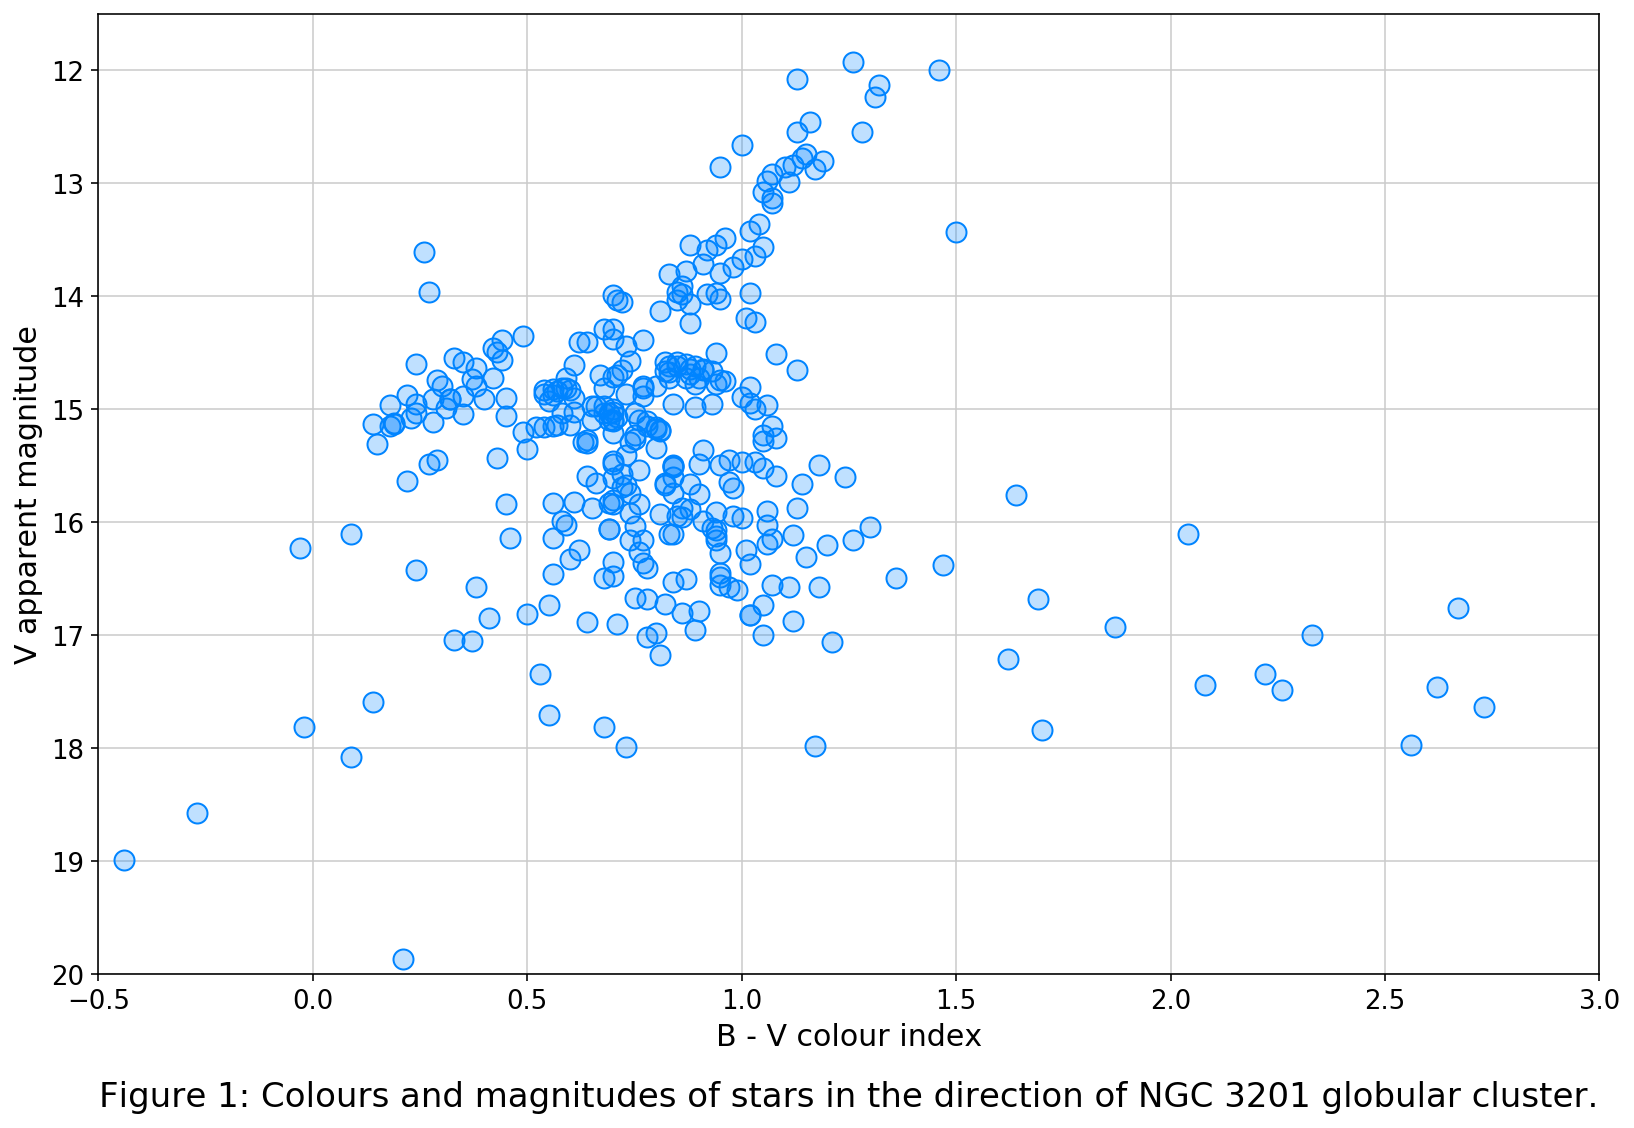

In [2]:
def save_plot(fig, plot_dir, file_name):
    """
    Save a plot to a file.
    
    Parameters
    ----------
    
    fig: matplotlib.figure.Figure
        Plot's figure
        
    plot_dir: str
        Directory where the plot file is placed.
        
    file_name: str
        Plot file name
    
    """
    
    if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)
    
    image_path = os.path.join(plot_dir, file_name)

    plt.savefig(image_path, fig=fig, dpi=150, transparent=False)



def make_cmd(data_path, blue_mag, red_mag,
             x_label, y_label, title, xlims, ylims,
             y_offset=0, x_offset=0, legend_label=None,
             title_offset=-0.15):   
    """
    Make a plot of colour magnitude diagram.
    
    Parameters
    ----------
        
    data_path: str
        Path to the CSV file containing magnitudes for stars.
        
    blue_mag, red_mag: str
        Names of the column containing magnitudes for the bluer and redder filters.
        
    x_label, y_label: str
        Axes labels.
        
    title: str
        Plot's title.
        
    xlims, ylims: (low, high)
        Limits for the axes.
        
    y_offset: float
        Offset that is added to the Y values of the observed data.
        
    legend_label: str
        Optional legend label.
        
    title_offset: float.
        A small negative number used to shift the title,
        so that it does not overlap with the plot. Adjusted manually.
    """

    # Read magnitudes and colors from CSV file
    df = pd.read_csv(data_path)

    # Create a figure and axis object
    fig, ax = plt.subplots(1, 1)
    
    # Drop rows with missing values
    df = df.dropna(subset=[blue_mag, red_mag])

    x_values = df[blue_mag] - df[red_mag]

    # Show plot
    ax.scatter(x_values + x_offset, df[red_mag] + y_offset, zorder=2,
               color="#0084ff40",
               edgecolor="#0084ff",
               label=legend_label)

    # Show grid
    ax.grid(zorder=-1)

    # Set plot labels
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    
    # Set axes limits
    # ------
    
    if xlims is not None:
        ax.set_xlim(xlims)
        
    if ylims is not None:
        ax.set_ylim(ylims)
        
    if title_offset is None:
        title_offset = -0.15
    
    ax.set_title(title, y=title_offset)  # Set image title

    # Invert y axis
    ax.invert_yaxis()
    
    return fig, ax 

    
  
magnitudes_dir = "../060_find_magnitudes/data"
magnitudes_path = os.path.join(magnitudes_dir, "magnitudes.csv")

all_plot_settings = [
    dict(magnitudes=["B", "V"], xlims=(-0.5, 3), ylims=(11.5, 20)),
]

figure_number = 0

for plot_settings in all_plot_settings:
    axes_magnitudes = plot_settings['magnitudes']

    if 'xlims' in plot_settings:
        xlims = plot_settings['xlims']
    else:
        xlims = None
        
    if 'ylims' in plot_settings:
        ylims = plot_settings['ylims']
    else:
        ylims = None
            
    blue_mag = axes_magnitudes[0]
    blue_mag_lowcase = blue_mag.lower()
    red_mag = axes_magnitudes[1]
    red_mag_lowcase = red_mag.lower()
    figure_number += 1
    
    title = (
        f"Figure {figure_number}: Colours and magnitudes "
        "of stars in the direction of NGC 3201 globular cluster."
    )
    
    fig, ax = make_cmd(data_path=magnitudes_path,
                       blue_mag=f"{blue_mag_lowcase}_mag",
                       red_mag=f"{red_mag_lowcase}_mag",
                       x_label=f"{blue_mag} - {red_mag} colour index",
                       y_label=f"{red_mag} apparent magnitude",
                       xlims=xlims, ylims=ylims,
                       title=title)
    
    # Expand the plot to the edges
    fig.tight_layout()

    save_plot(fig=fig,
              file_name=f"cmd_{blue_mag_lowcase}_{red_mag_lowcase}.png",
              plot_dir="images")

## Does CMD look right?

Hmm, I don't see a main sequence on Fig. 1. In order to understand which stars am I looking at, I compare our plot with [Layden et al. (2003)]((https://ui.adsabs.harvard.edu/abs/2003AJ....125..208L/abstract)) on Fig. 2.

* It looks like we don't have any meain sequence stars on our plot (right panel), so we can't use main sequence matching to find the distance to our globular cluster.


I posted Fig. 2 on the forum, here is response from Michael Brown:

> you cannot use main sequence fitting for the GC distance (and age), but you can use the red giant branch and isochrones in the same way. Indeed, you could have fun over plotting 100 Myr, 1 Gyr and 10 Gyr isochrones on your plot using the same distance modulus.

> There are tables of red giant colours and magnitudes available too, so you can do a cross check without relying on the isochrones alone.

Great! Let's try fitting Girardi isochrones and find distance and age.

![Comparison with Layden et al. 2003](images/ngc_3201_locating_main_sequence.png)

Figure 2: Comparison of color magnitude diagram: left is Fig. 2 from [Layden et al. (2003)](https://ui.adsabs.harvard.edu/abs/2003AJ....125..208L/abstract), and the right is from our magnitude measurements. I drawn the evolutionary tracks by eye based on Layden. It appear that we don't have any main sequence stars in our data. However, I can see horizontal branch and giant stars, which is great.

## Plot Girardi isochrone

I generate a Girardi isochrone:

* Go to http://stev.oapd.inaf.it/cgi-bin/cmd
* Set linear age (yr) to 12e9, based on [Monty et al. 2018](https://ui.adsabs.harvard.edu/abs/2018ApJ...865..160M/abstract) estimate of 12.2 ± 0.5
* Set metallicity [M/H] to -1.5, based on [Marino et al. (2019)](https://arxiv.org/abs/1910.02892) estimate of −1.50 ± 0.02 (rms=0.07 dex).

Next, I plot the isochrone:

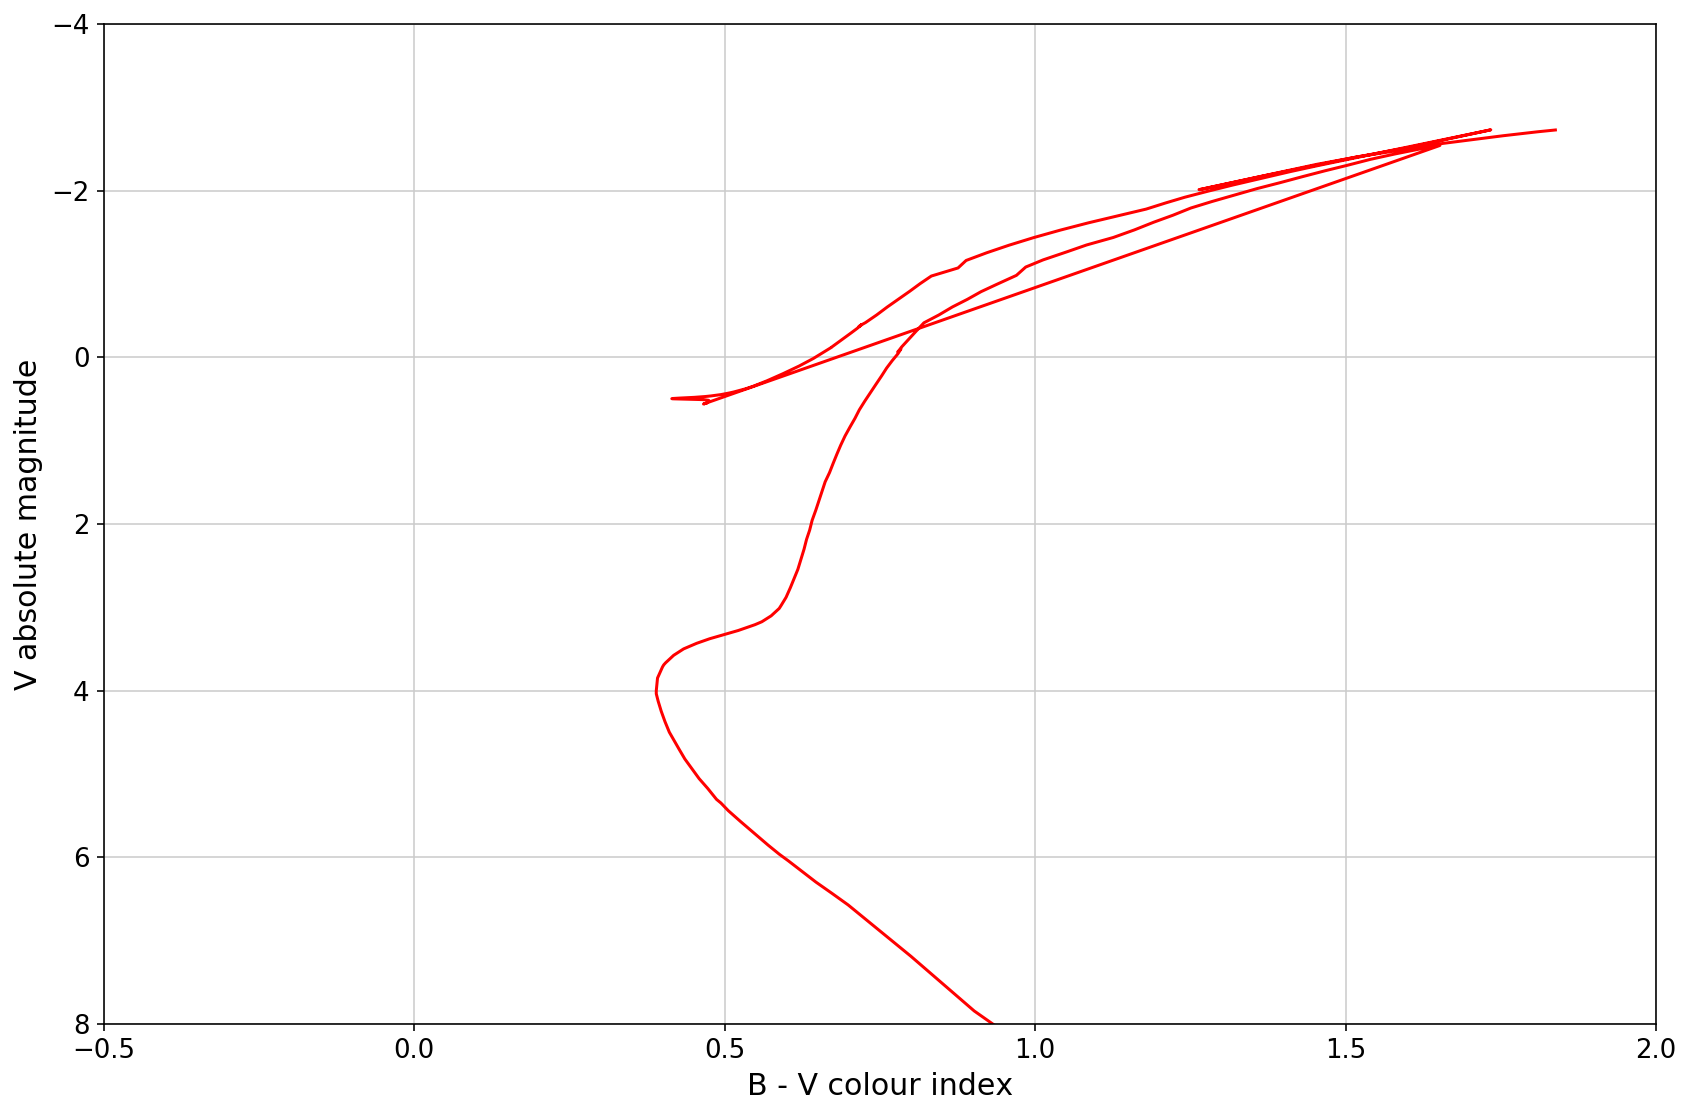

In [3]:
def read_girardi_data(data_path):
    """
    Read Girardi isochrone data file,
    i.e. the file produced by http://stev.oapd.inaf.it/cgi-bin/cmd web site
    
    Parameters
    ----------
    
    data_path: str
        Path to data file
        
    Returns
    -------
    pandas.core.frame.DataFrame
        Data for Girardi iscochrone.
    """
    
    # Open text file
    with open(data_path) as file:
        file_text = file.read()
        # Remove comment character from header line
        file_text = file_text.replace('# Zini', "Zini")
        
        # Delete all comments
        file_text = re.sub(r'^#.*\n?', '', file_text, flags=re.MULTILINE) 
        
        # Remove last line
        file_text = file_text[:file_text.rfind('\n',  0, len(file_text) - 1)]
    
    data = StringIO(file_text)

    # Read the data from text table,
    # using any whitespace characters as column separators
    return pd.read_table(data, delimiter='\s+')


def plot_isochrone(plot_dir, file_name, data_path):  
    """
    Make a plot of a Girardi isochrone.
    
    Parameters
    ----------
    plot_dir: str
        Directory where the plot file is placed.
        
    file_name: str
        Plot file name.
        
    data_path: str
        Path to the text file output from http://stev.oapd.inaf.it/cgi-bin/cmd

    """
    
    df = read_girardi_data(data_path)

    # Create a figure and axis object
    fig, ax = plt.subplots(1, 1)

    # Show plot
    ax.plot(df["Bmag"] - df["Vmag"], df["Vmag"], zorder=2, c='red')

    # Set axes limits
    ax.set_xlim(-0.5, 2)
    ax.set_ylim(-4, 8)

    # Show grid
    ax.grid(zorder=-1)

    # Set plot labels
    ax.set_xlabel("B - V colour index")
    ax.set_ylabel("V absolute magnitude")

    # Invert y axis
    ax.invert_yaxis()

    # Expand the plot to the edges
    fig.tight_layout()

    save_plot(fig=fig, file_name=file_name, plot_dir=plot_dir)
    

plot_isochrone(plot_dir="images", file_name="girardi_12gyr.png",
               data_path="data/girardi/-1.5/12.00_gyr.txt")

Figure 3: Girardi isochrone, 12 Gyr, [M/H]=-1.5.

In [4]:
figure_number = 3

## Fitting data to Girardi isochrone

First, I shift our measurements from Fig. 1 vertically (i.e. shift the V values) in order to match Girardi isochrone.

* I manually choose the amount of shift, which happens to be about 14.5 so that the observed giant branch is best matched with that from Girardi isochrone,
* This number is $(m - M)_V$, aka apparent visual distance modulus.

Next, I shift the measurements from Fig. 1 horizontally (i.e. shift the B-V values). This is done to compensate for reddening.


### What on Earth is "reddening"?

Well, it turns out, the light is sometimes blocked by stuff and blue light is blocked more than red light. For example, the sunsets are red because there is a lot of air the light goes through when the sun is on the horizon, and this air blocks blue light more than red light (why? I don't know). Similarly, the blue light from NGC 3201 is blocked more than red light, so the stars we observed are more red than they really are. This is called "reddening".


### How do I correct for reddening?

I need to make our measurements from Fig. 1 bluer, so I need to subtract some number from B-V values. This reddening number is $E(B-V)=0.25 \pm 0.01$, it was calculated by [Monty et al. 2018](https://arxiv.org/abs/1808.05271). So what I do here is to subtract 0.25 from all B-V values on Fig. 1.

## Calculating distance

The point of all this trouble is to calculate the distance to NGC 3201. I can use equation

$$(m-M)_0 = 5 \log_{10} \left( \frac{d}{10 \ \text{pc}} \right) \quad \quad (1)$$

to calculate distance $d$ in parsecs. Notice that here $(m-M)_0$ is the *true distance modulus*. This is the distance modulus we would calculate if the light was not blocked by dust. To calculate $(m - M)_0$ I subtract extinction number $A_V$ from my $(m - M)_V = 14.5$:

$$(m - M)_0 = (m - M)_V - A_V.  \quad \quad (2)$$

Here, I calculate $A_V$ using the reddening value $E(B-V)=0.25$, multiplied by $R_V=3.1$ [O'Donnell (1994)](https://ui.adsabs.harvard.edu/abs/1994ApJ...422..158O/abstract):

$$A_V = R_V E(B-V) = 3.1 * 0.25 = 0.775.$$

Why? I have no idea. Substituting $A_V=0.775$ and $(m - M)_V = 14.5$ into Eq. 2 gives:

$$(m - M)_0 = (m - M)_V - A_V = 14.5 - 0.775 = 13.725.$$

Finally, I solve Eq. 1 for distance $d$, substitute $(m - M)_0$ calculate the distance I wanted:

$$d = (10) \left(10^{13.725/5}\right) \approx 5500 \ \text{pc}.$$

I am done!

In [5]:
def calculate_distance(apparent_distance_modulus, reddening, r_v=3.1):
    """
    Calculate distance given apparent distance modulus.
    
    Parameters
    ----------
    
    apparent_distance_modulus: float
        Apparent visual distance modulus
    
    reddening: float
        Reddening, aka E(B - V).
        Extinction correction value of the (B-V) colour.
        
    r_v: float
        Total-to-selective extinction ratio value that is dependent upon the
        density of the interstellar medium. Default value 3.1 form O'Donnell (1994)
        https://ui.adsabs.harvard.edu/abs/1994ApJ...422..158O/abstract
    """

    # Calculate true distance modulus
    true_distance_modulus = apparent_distance_modulus - r_v * reddening

    # Calculate the distance
    return 10 * 10**(true_distance_modulus / 5)


def plot_cmd_with_girardi(plot_dir, file_name,
                          magnitudes_path, girardi_path,
                          x_label, y_label, xlims, ylims,
                          title, title_offset,
                          distance_modulus, reddening, text, show=False):
    """
    Plot V vs B-V color magnitude diagram containing observations and Girardi isochrone.
    
    Parameters
    ----------
    plot_dir: str
        Directory where the plot file is placed.
        
    file_name: str
        Plot file name.
        
        
    girardi_path: str
        Path to the text file output from http://stev.oapd.inaf.it/cgi-bin/cmd
        
    magnitudes_path: str
        Path to the CSV file containing magnitudes for stars.
        
    x_label, y_label: str
        Axes labels.
        
    xlims, ylims: (low, high)
        Limits for the axes.
        
    title: str
        Plot's title.
        
    text: str
        Text shown in a text box on the plot.
        
    title_offset: float.
        A small negative number used to shift the title,
        so that it does not overlap with the plot. Adjusted manually.
        
    distance_modulus: float
        Apparent visual distance modulus.
        Used for shifting the observed data along the Y-axis
        and calculating the distance.
        
    reddening: float
        Reddening, aka E(B - V).
        Extinction correction value of the (B-V) colour. 
        
    show: bool
        If True, this image is shown in the Notebook. 
    """    

    fig, ax = make_cmd(data_path=magnitudes_path,
                       blue_mag=f"b_mag",
                       red_mag=f"v_mag",
                       x_label=x_label,
                       y_label=y_label,
                       xlims=xlims, ylims=ylims,
                       title=title,
                       title_offset=title_offset,
                       legend_label="Observations")
    
    df = read_girardi_data(girardi_path)

    # Plot Girardi isochrone
    # ------
    
    # Make colors redder
    x_values = df["Bmag"] - df["Vmag"] + reddening
    
    # Make magnitudes dimmer
    y_values = df["Vmag"] + distance_modulus
    
    ax.plot(x_values, y_values,
            zorder=2, c='red', label="Girardi isochrone")
    
    # Show text box
    text = plt.text(
        0.033, 0.1,
        text,
        horizontalalignment='left',
        verticalalignment='center',
        transform=ax.transAxes,
        bbox=dict(facecolor='white', boxstyle='round', alpha=0.8, edgecolor='0.7'))

    # Expand the plot to the edges
    fig.tight_layout()
    
    # Show legend
    ax.legend(loc='upper left')

    # Save plot to file
    save_plot(fig=fig, file_name=file_name, plot_dir=plot_dir)
    
    if show:
        plt.show()

    # Close figure to free up memory
    plt.close(fig)


def plot_cmd_with_girardi_with_title(plot_dir, distance_modulus, reddening,
                                     figure_number, girardi_dir, girardi_age_gyr,
                                     girardi_metallicity, r_v=3.1, show=False):
    """
    Make the plot of observations with Girardi isochrone,
    with full title, containing different parameters.
    
    Parameters
    ----------
    plot_dir: str
        Directory where the plot file is placed.
        
    distance_modulus: float
        Apparent visual distance modulus.
        Used for shifting the observed data along the Y-axis
        and calculating the distance.
        
    reddening: float
        Reddening, aka E(B - V).
        Extinction correction value of the (B-V) colour. 
        
    file_name: str
        Plot file name.
        
    girardi_dir: str
        Path to where Girardi isochrones are located.
        
    girardi_age_gyr: float
        Are used to generate the Figardi isochrone, in Gyr. Example: 12.
        
    girardi_metallicity: float
        Metallicity used to generate Figardi isochrone [M/H]. Example: -1.
        
    r_v: float
        Total-to-selective extinction ratio value that is dependent upon the
        density of the interstellar medium. Default value 3.1 form O'Donnell (1994)
        https://ui.adsabs.harvard.edu/abs/1994ApJ...422..158O/abstract   

    show: bool
        If True, this image is shown in the Notebook.
    """

    distance = calculate_distance(apparent_distance_modulus=distance_modulus,
                                  reddening=reddening, r_v=r_v)
    
    # Round the distance
    distance = round(distance / 100) * 100

    # Set plot title
    title = (
        f"Figure {figure_number}: Fitting Girardi isochrones to observed stars "
        "in direction of NGC 3201"
    )
    
    # Set text shown in a box on the plot
    text = (
        f"Age: {girardi_age_gyr:.2g} Ga\n"
        f"[M/H]: {girardi_metallicity:.1f}\n"
        "$(m-M)_V: $"
        f"{distance_modulus}\n"
        f"Distance: {distance} pc"
    )
    
    girardi_path = os.path.join(girardi_dir, f'{girardi_metallicity:.1f}',
                                f'{girardi_age_gyr:.2f}_gyr.txt')
    
    plot_file_name = f'cmd_{distance_modulus:.2f}mag__{girardi_age_gyr:.2f}gyr.png'
    
    print(plot_file_name)
    
    plot_cmd_with_girardi(plot_dir=plot_dir,
                          file_name=plot_file_name,
                          magnitudes_path=magnitudes_path,
                          xlims=(-0.5, 2), ylims=(10, 20),
                          x_label="B - V colour index",
                          y_label="V apperant magnitude",
                          distance_modulus=distance_modulus,
                          reddening=reddening,
                          girardi_path=girardi_path,
                          title=title,
                          title_offset=None,
                          text=text,
                          show=show)
    
def delete_dir_if_exists(dir):
    """
    Creates a directory if exists exist.

    Parameters
    ----------
    dir : str
        Directory path, can be nested directories.

    """
    if os.path.exists(dir):
        shutil.rmtree(dir)


def create_dir(dir):
    """
    Creates a directory if it does not exist.

    Parameters
    ----------
    dir : str
        Directory path, can be nested directories.

    """

    if not os.path.exists(dir):
        os.makedirs(dir)
        

def is_tool(name):
    """Check whether `name` is on PATH and marked as executable."""

    return which(name) is not None

        
def make_movie(plot_dir, movie_dir, out_file):
    """
    Creates a movie .mp4 file from individual images.

    Parameters
    ----------
    plot_dir : str
        Path to directory containing individual images for the movie.

    movie_dir : str
        The output directory of the movie.
        
    out_file: str
        Name of the output movie file.
    """
    
    # Temporary movie path
    src_movie = os.path.join(plot_dir, out_file)

    # Remove temporary movie if exists
    if os.path.exists(src_movie):
        os.remove(src_movie)

    # Check if ffmpeg is installed
    if not is_tool("ffmpeg"):
        raise RuntimeError("ERROR: ffmpeg is not installed. Install ffmpeg program.")

    # Run ffmpeg to make the movie
    # ----------
    
    command = (f"ffmpeg -framerate 1 -pattern_type glob -i '*.png' "
               f"-c:v libx264 -pix_fmt yuv420p {out_file}")

    subprocess.call(command, cwd=plot_dir, shell=True)

    # Copy movie to output directory
    # ----------

    dest_movie = os.path.join(movie_dir, out_file)
    create_dir(movie_dir)

    if os.path.exists(dest_movie):
        os.remove(dest_movie)

    copyfile(src_movie, dest_movie)
    print(f"Movie saved to {dest_movie}")
    
    # Remove temporary movie file
    # ------
    os.remove(src_movie)

In [6]:
# Directory with Girardi isochrones
girardi_dir = "data/girardi"

# Directory where temporary images for fitting are created
fit_images_dir = "images/fitting"

# Reddening, aka E(B - V)
# Value from Monty et al. 2018, https://arxiv.org/abs/1808.05271
reddening = 0.25
    
# Fit Girardi isochrone for observations.
# Create a movie of the fits for each Girardi metallicity value [M/H]
for girardi_metallicity in [-1, -1.5, -2]:
    # Remove fit directory if exists
    if os.path.exists(fit_images_dir):
        shutil.rmtree(fit_images_dir)
        
    # Create plot images
    # ----------

    print(f"\nMaking plots for [M/H]={girardi_metallicity:.1f}")
    
    # Iterate over distance moduli
    for distance_modulus in [13, 13.5, 14, 14.3, 14.6]:
        # Iterate over Girardi ages (Gyr)
        for girardi_age_gyr in range(10, 17):
            figure_number += 1

            plot_cmd_with_girardi_with_title(plot_dir=fit_images_dir,
                                             distance_modulus=distance_modulus,
                                             reddening=reddening,
                                             figure_number=figure_number,
                                             girardi_dir=girardi_dir,
                                             girardi_age_gyr=girardi_age_gyr,
                                             girardi_metallicity=girardi_metallicity)


    # Make a movie from plot images
    print("Making movie...")
    movie_file_name = f"cmd_fit_{girardi_metallicity:.1f}.mp4"
    make_movie(plot_dir=fit_images_dir, movie_dir="movies", out_file=movie_file_name)
    
    
# Cleanup: remove fit directory
if os.path.exists(fit_images_dir):
    shutil.rmtree(fit_images_dir)
        
print("We are done!")


Making plots for [M/H]=-1.0
cmd_13.00mag__10.00gyr.png
cmd_13.00mag__11.00gyr.png
cmd_13.00mag__12.00gyr.png
cmd_13.00mag__13.00gyr.png
cmd_13.00mag__14.00gyr.png
cmd_13.00mag__15.00gyr.png
cmd_13.00mag__16.00gyr.png
cmd_13.50mag__10.00gyr.png
cmd_13.50mag__11.00gyr.png
cmd_13.50mag__12.00gyr.png
cmd_13.50mag__13.00gyr.png
cmd_13.50mag__14.00gyr.png
cmd_13.50mag__15.00gyr.png
cmd_13.50mag__16.00gyr.png
cmd_14.00mag__10.00gyr.png
cmd_14.00mag__11.00gyr.png
cmd_14.00mag__12.00gyr.png
cmd_14.00mag__13.00gyr.png
cmd_14.00mag__14.00gyr.png
cmd_14.00mag__15.00gyr.png
cmd_14.00mag__16.00gyr.png
cmd_14.30mag__10.00gyr.png
cmd_14.30mag__11.00gyr.png
cmd_14.30mag__12.00gyr.png
cmd_14.30mag__13.00gyr.png
cmd_14.30mag__14.00gyr.png
cmd_14.30mag__15.00gyr.png
cmd_14.30mag__16.00gyr.png
cmd_14.60mag__10.00gyr.png
cmd_14.60mag__11.00gyr.png
cmd_14.60mag__12.00gyr.png
cmd_14.60mag__13.00gyr.png
cmd_14.60mag__14.00gyr.png
cmd_14.60mag__15.00gyr.png
cmd_14.60mag__16.00gyr.png
Making movie...
Movie save

## Fitting videos

Watch the videos of all the plots I made above:

* [M/H]=-1.0: [https://youtu.be/d5S5QkF6LlY](https://youtu.be/d5S5QkF6LlY)

* [M/H]=-1.5: [https://youtu.be/DgaelLLoA6Y](https://youtu.be/DgaelLLoA6Y)

* [M/H]=-2.0: [https://youtu.be/tVUJav2DzSo](https://youtu.be/tVUJav2DzSo)

## Best Girardi fits

I've selected the best fits, shown on Figures 109-113. Parameters are:

* For [M/H]=-1.5, distance 5100 pc, age 16 Ga.

* For [M/H]=-2.0, distances 4400-5100 pc with ages 15-16 Ga.

cmd_14.30mag__16.00gyr.png


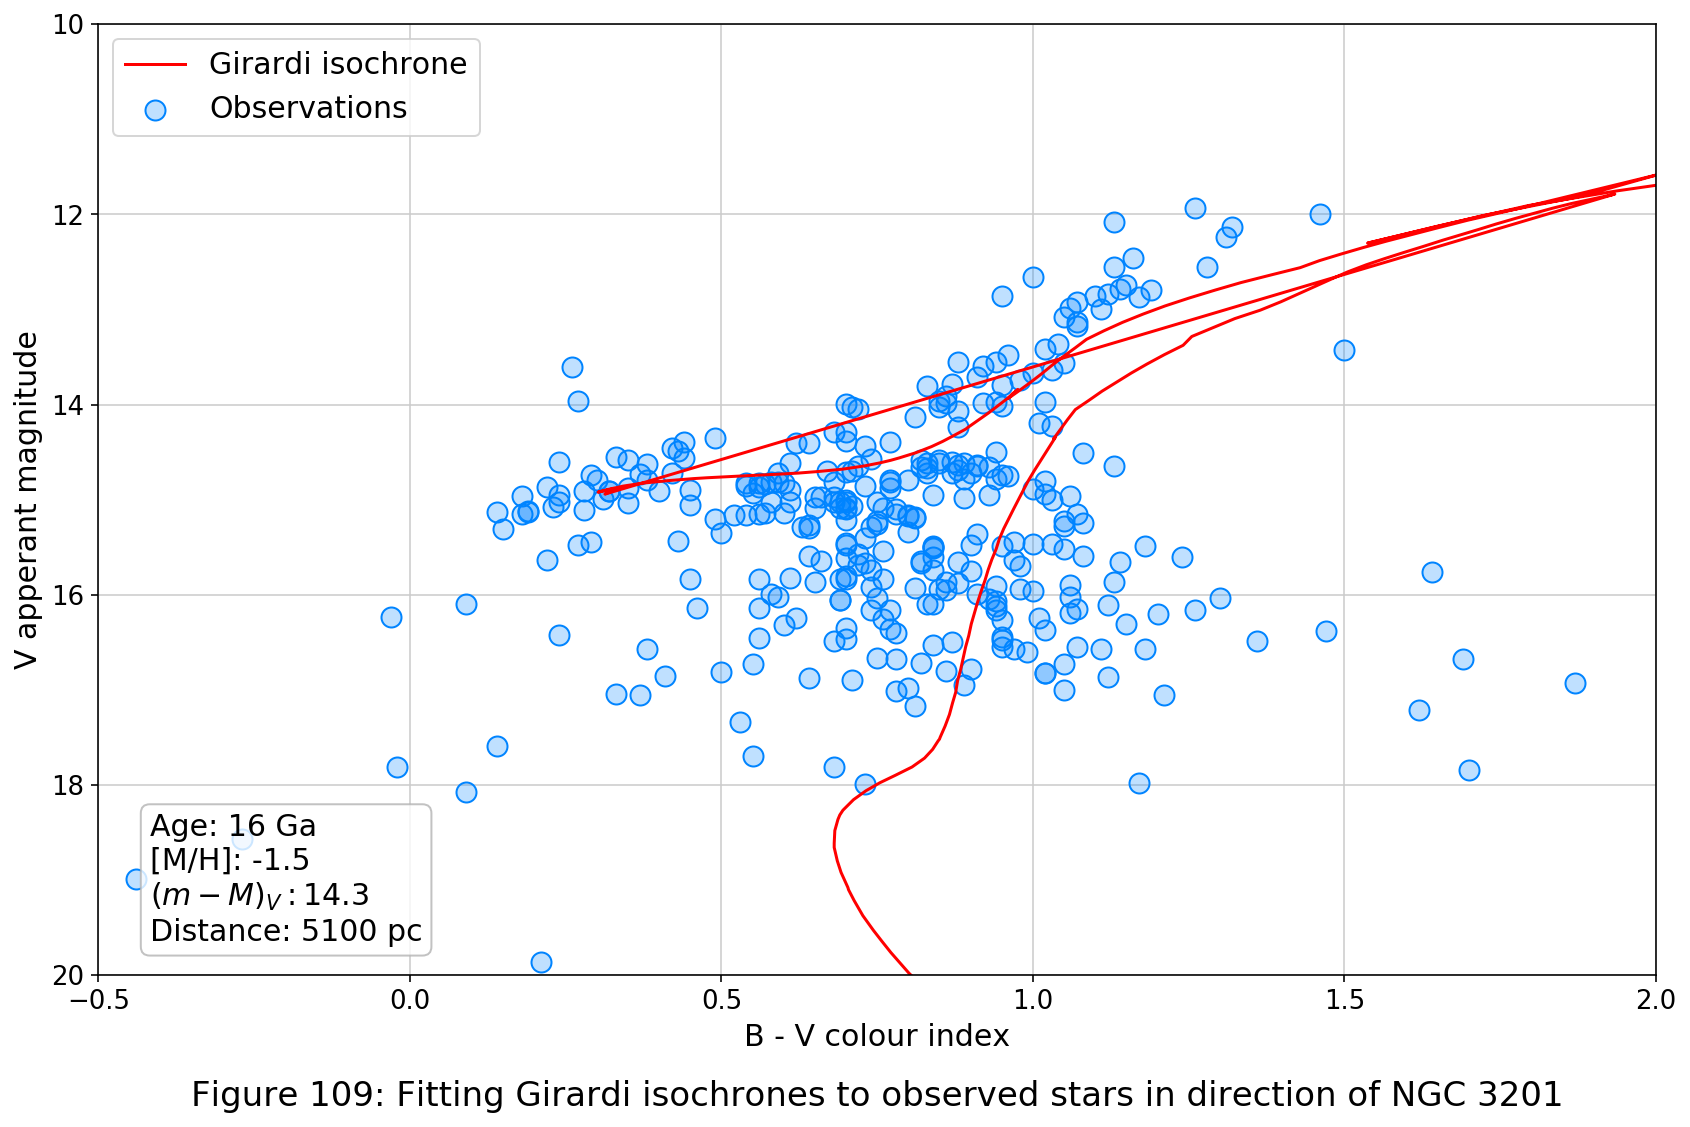

cmd_14.00mag__15.00gyr.png


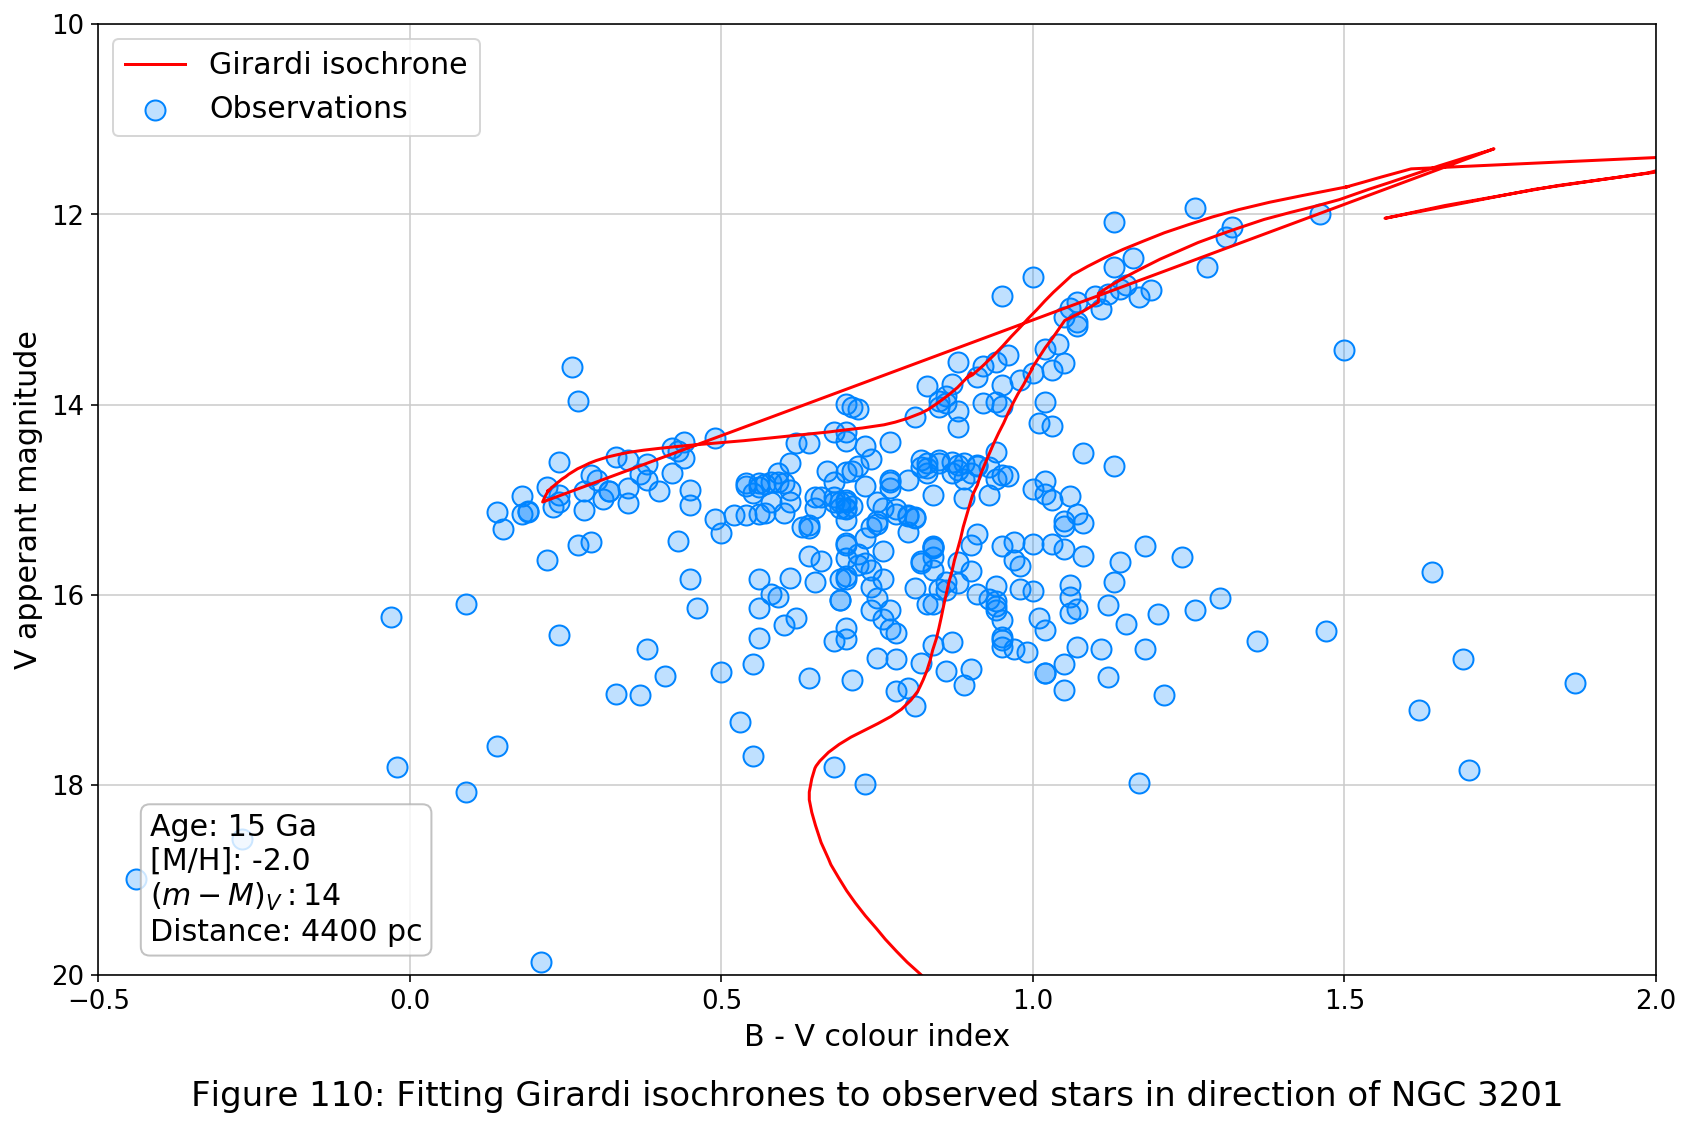

cmd_14.00mag__16.00gyr.png


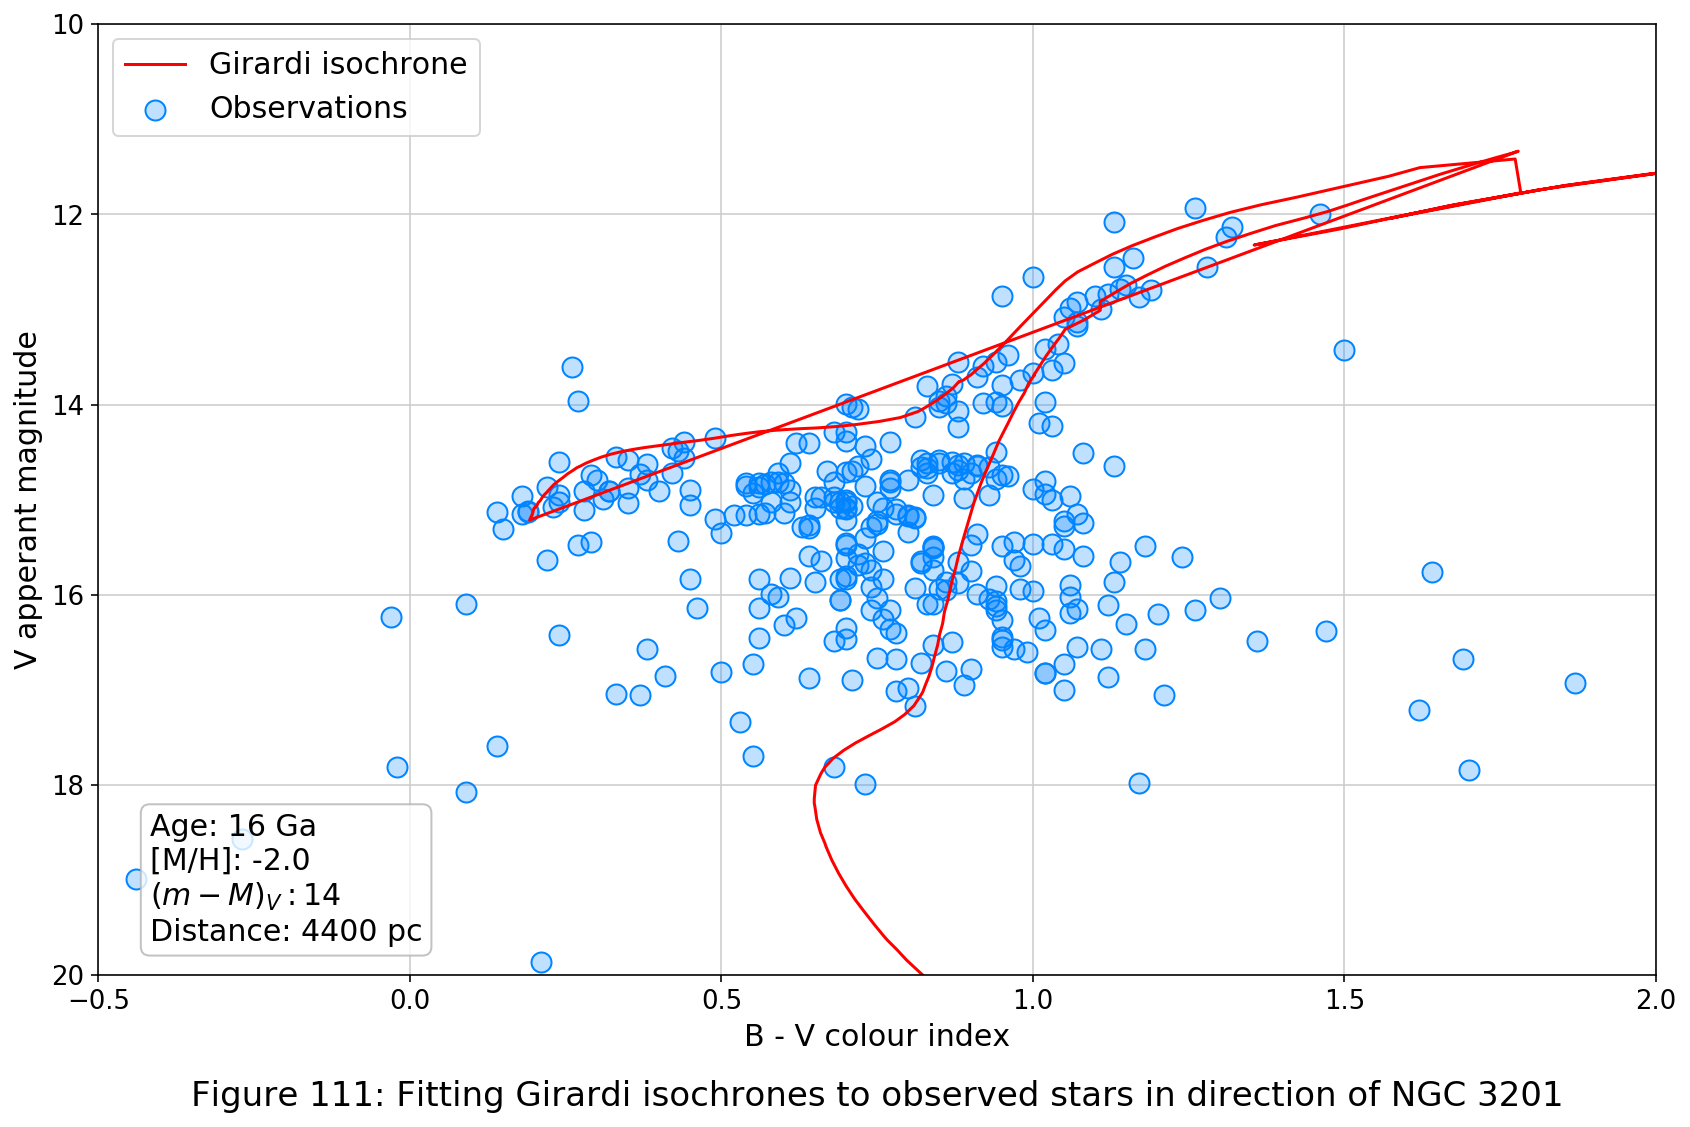

cmd_14.30mag__15.00gyr.png


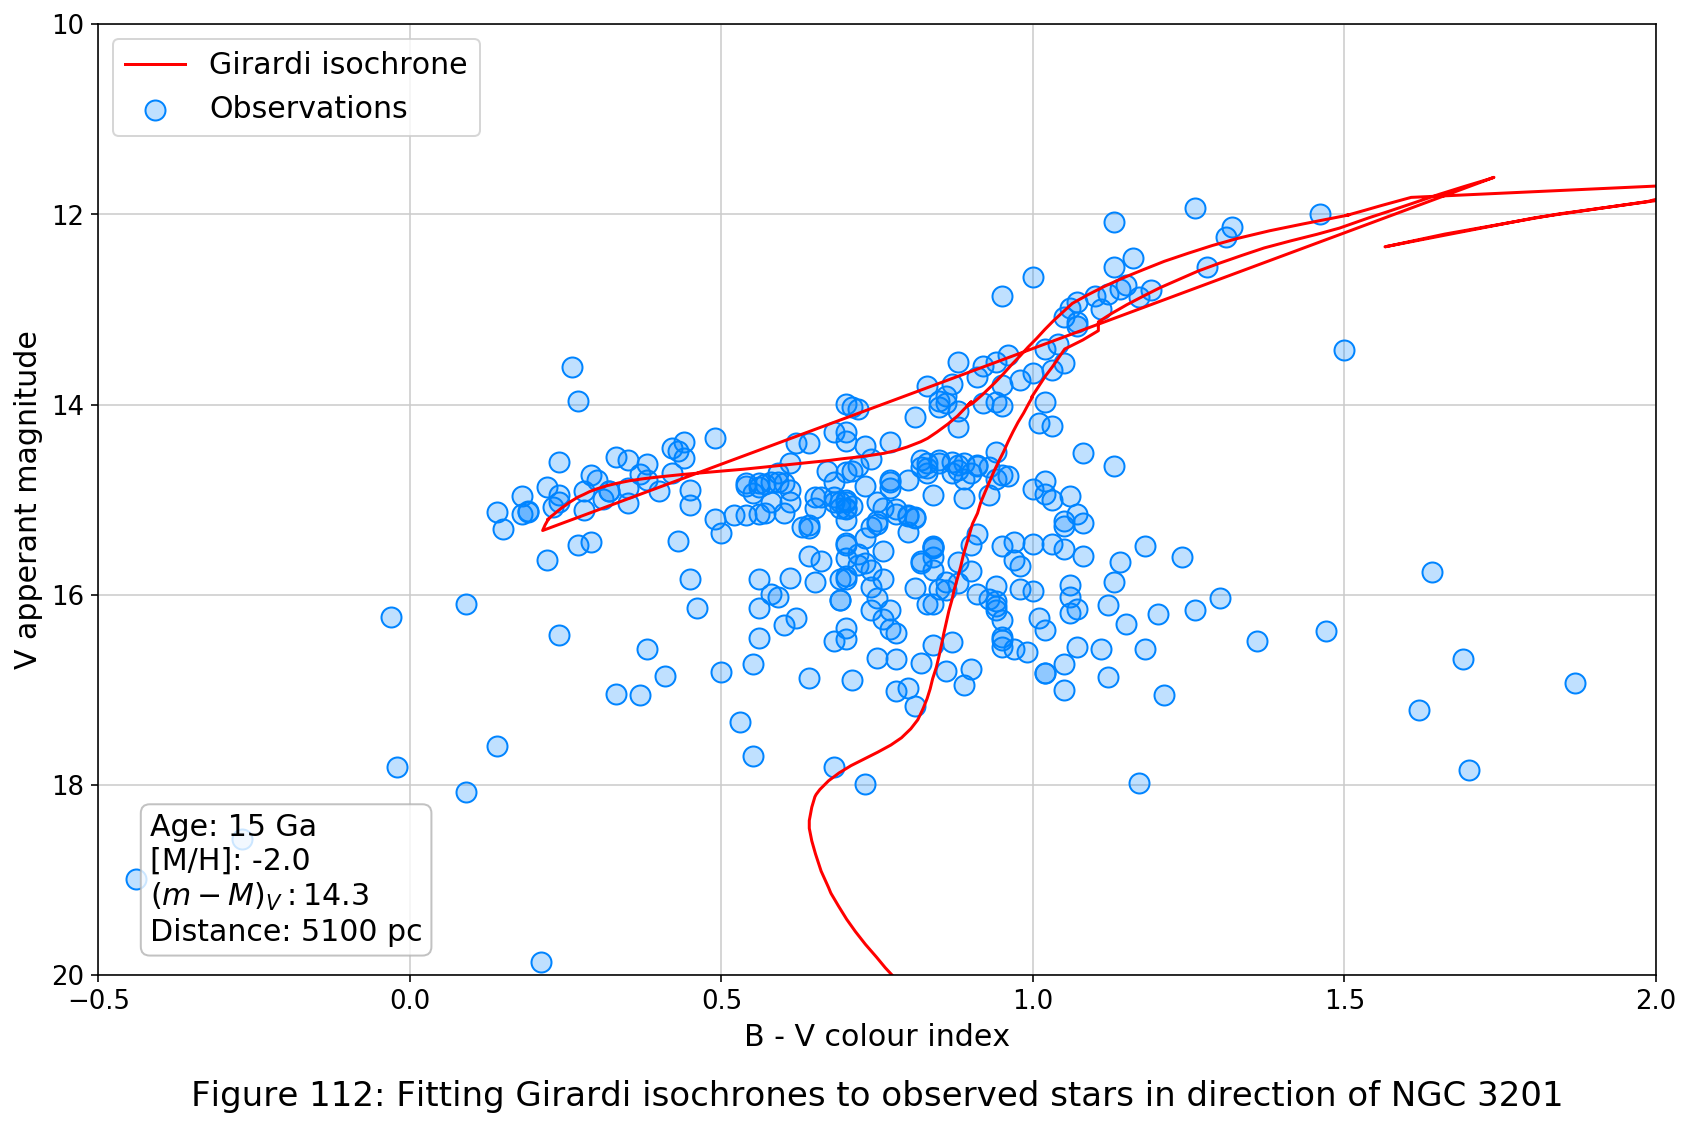

cmd_14.30mag__16.00gyr.png


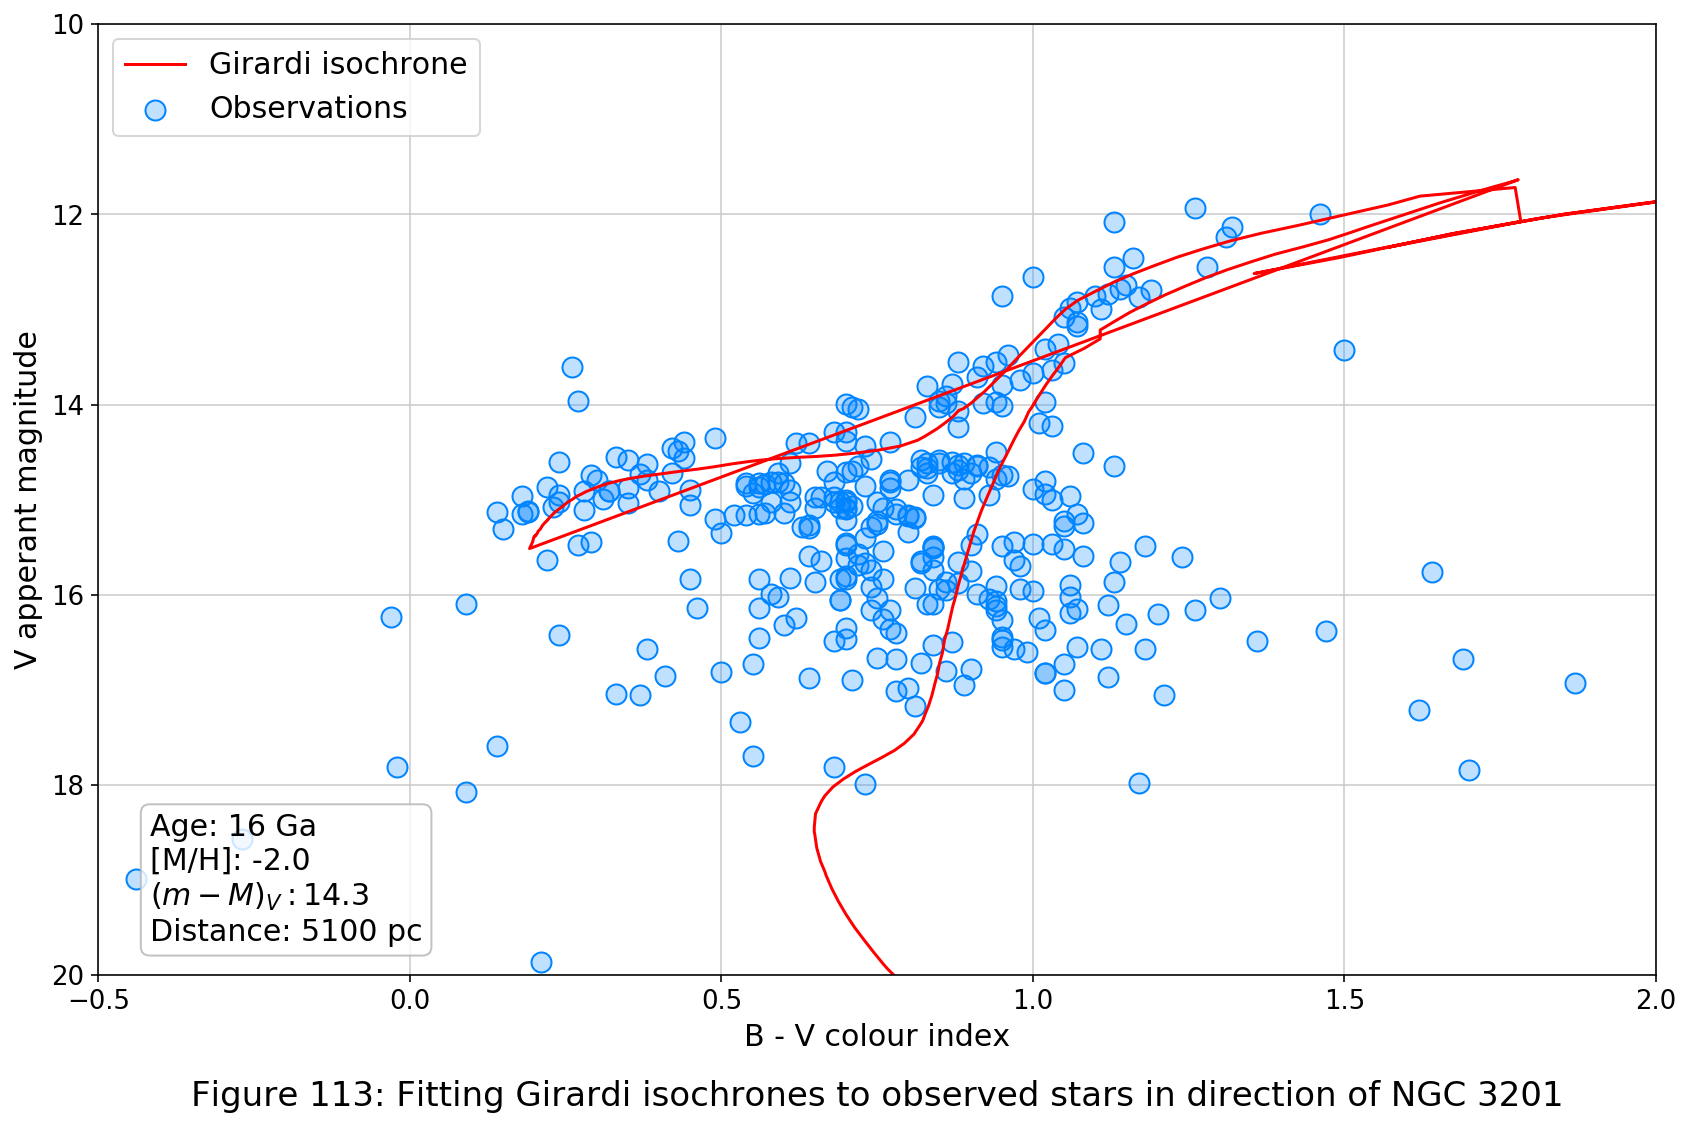

In [7]:
fit_images_dir = "images/good_fits"

good_fits = [
    dict(distance_modulus=14.3, age=16, metallicity=-1.5),
    dict(distance_modulus=14, age=15, metallicity=-2),
    dict(distance_modulus=14, age=16, metallicity=-2),
    dict(distance_modulus=14.3, age=15, metallicity=-2),
    dict(distance_modulus=14.3, age=16, metallicity=-2),
]

for good_fit in good_fits:
    figure_number += 1

    plot_cmd_with_girardi_with_title(plot_dir=fit_images_dir,
                                     distance_modulus=good_fit['distance_modulus'],
                                     reddening=reddening,
                                     figure_number=figure_number,
                                     girardi_dir=girardi_dir,
                                     girardi_age_gyr=good_fit['age'],
                                     girardi_metallicity=good_fit['metallicity'],
                                     show=True)

In [12]:
print("We are done!")

We are done!
